In [91]:
# 📌 1. Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path


Path("../data/processed").mkdir(parents=True, exist_ok=True)
Path("../splits").mkdir(parents=True, exist_ok=True)


In [92]:
# 📌 2. Load Raw Dataset
df = pd.read_csv("./data/raw/dataset-uci.csv")

print("Shape:", df.shape)
df.head()


Shape: (319, 39)


,Gallstone Status,Age,Gender,Comorbidity,Coronary Artery Disease (CAD),Hypothyroidism,Hyperlipidemia,Diabetes Mellitus (DM),Height,Weight,...,High Density Lipoprotein (HDL),Triglyceride,Aspartat Aminotransferaz (AST),Alanin Aminotransferaz (ALT),Alkaline Phosphatase (ALP),Creatinine,Glomerular Filtration Rate (GFR),C-Reactive Protein (CRP),Hemoglobin (HGB),Vitamin D
0,0,50,0,0,0,0,0,0,185,92.8,...,40.0,134.0,20.0,22.0,87.0,0.82,112.47,0.0,16.0,33.0
1,0,47,0,1,0,0,0,0,176,94.5,...,43.0,103.0,14.0,13.0,46.0,0.87,107.10,0.0,14.4,25.0
2,0,61,0,0,0,0,0,0,171,91.1,...,43.0,69.0,18.0,14.0,66.0,1.25,65.51,0.0,16.2,30.2
3,0,41,0,0,0,0,0,0,168,67.7,...,59.0,53.0,20.0,12.0,34.0,1.02,94.10,0.0,15.4,35.4
4,0,42,0,0,0,0,0,0,178,89.6,...,30.0,326.0,27.0,54.0,71.0,0.82,112.47,0.0,16.8,40.6


In [93]:
# 📌 3. Define Target Column
TARGET = "Gallstone Status"

df[TARGET].value_counts(normalize=True).mul(100).round(1)


Gallstone Status
0    50.5
1    49.5
Name: proportion, dtype: float64

In [94]:
# 📌 4. Create Splits (70/15/15 stratified)

# Train vs temp (val+test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df[TARGET],
    random_state=42
)

# Val vs test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df[TARGET],
    random_state=42
)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)


Train: (223, 39) Val: (48, 39) Test: (48, 39)


In [95]:
import json, joblib, glob

# Load latest metadata
meta_file = sorted(glob.glob("models/model_metadata_*.json"))[-1]
with open(meta_file) as f:
    metadata = json.load(f)

# Load calibrated pipeline
calib_pipeline = joblib.load(metadata["calibrated_model_path"])

# Load raw pipeline for SHAP
raw_pipeline = joblib.load(metadata["raw_model_path"])
preprocessor = raw_pipeline.named_steps["preprocessor"]
xgb_estimator = raw_pipeline.named_steps["classifier"]

# ✅ Fix: key is 'features' not 'feature_names'
feature_names = metadata.get("features", [])

print("✅ Loaded models from:", meta_file)
print("✅ Features:", len(feature_names))


✅ Loaded models from: models\model_metadata_20250917_180446.json
✅ Features: 38


### Load test set & saved model
- load `data/processed/test.csv` and split into `X_test` / `y_test`.  
- then load the artifact `models/best_model_XGB_sigmoid.joblib`.  
  - In our workflow i saved a dictionary `{ "model": calibrated_model, "threshold": float }`.  
  - then extract the calibrated wrapper into `calib_model`.  
- Print statements help verify the structure before proceeding.


In [97]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")


In [98]:
# --- Define X_test and y_test from test_df ---
X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET]

feature_names = X_test.columns.tolist()


In [99]:
feature_names = test_df.columns.tolist()


In [100]:
import shap, numpy as np
import pandas as pd

# --- Ensure X_test is always a DataFrame with feature names ---
if not isinstance(test_df, pd.DataFrame):
    X_test = pd.DataFrame(test_df, columns=feature_names)

# Transform X_test for SHAP with preserved feature names
X_test_transformed = preprocessor.transform(X_test)

# Convert sparse -> dense if needed
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# Background sample
bg = metadata.get("background", X_test_transformed[:100])

# SHAP explainer using raw XGBoost estimator
explainer = shap.TreeExplainer(xgb_estimator, data=bg, feature_names=feature_names)
shap_values = explainer(X_test_transformed)

print("✅ SHAP values shape:", shap_values.shape)


✅ SHAP values shape: (48, 38)


### Unwrap pipeline & locate preprocessor + XGBoost estimator
The calibrated model wraps a pipeline (preprocessor → XGBClassifier). SHAP cannot explain pipelines, so let's extract the raw XGBClassifier. and let's also pass the test set through the same preprocessing steps used during training, ensuring SHAP explains the actual features the model sees.


In [102]:
# Example: calibrated probability predictiony_pred_proba = calib_pipeline.predict_proba(X_test)[:, 1]
y_pred_proba = calib_pipeline.predict_proba(X_test)[:, 1]

print("Example calibrated probabilities:", y_pred_proba[:10])


Example calibrated probabilities: [0.0976304  0.06243257 0.17142595 0.07250407 0.14714947 0.91919124
 0.89474142 0.92554116 0.83029366 0.05994137]


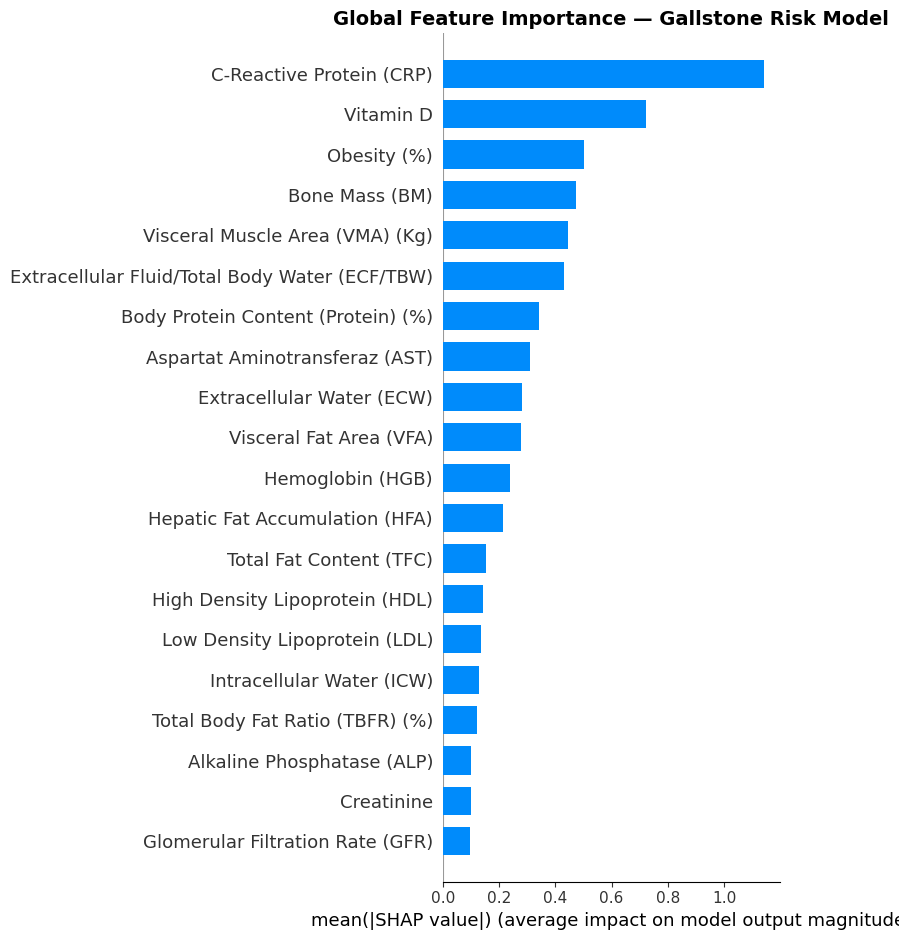

Saved global SHAP bar plot -> models\shap_global_bar.png


In [199]:
# ✅ Global SHAP Bar Plot (original feature names)
import shap
import matplotlib.pyplot as plt
import os

# compute shap values if not already done
# shap_values = explainer(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Global Feature Importance — Gallstone Risk Model", fontsize=14, weight="bold")
plt.tight_layout()

# Save + show
bar_path = os.path.join("models", "shap_global_bar.png")
plt.savefig(bar_path, dpi=150, bbox_inches="tight")
plt.show()   # <-- display inside notebook
plt.close()
print(f"Saved global SHAP bar plot -> {bar_path}")


### Global Plot( BarPLot)
This bar chart shows which features are the most important for the model overall.

    *Features at the top have the strongest influence on predictions.
    *Larger bars mean a bigger average effect on risk.


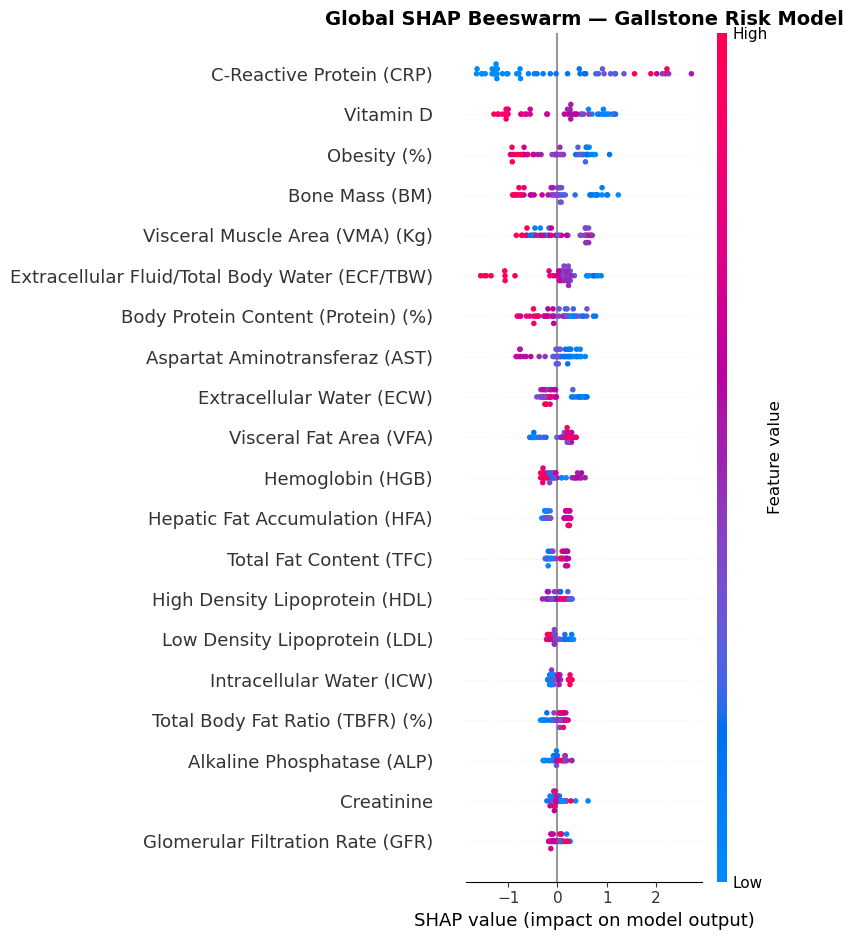

Saved global SHAP beeswarm plot -> models\shap_global_beeswarm.png


In [201]:
# ✅ Global SHAP Beeswarm Plot (original feature names)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Global SHAP Beeswarm — Gallstone Risk Model", fontsize=14, weight="bold")
plt.tight_layout()

# Save + show
beeswarm_path = os.path.join("models", "shap_global_beeswarm.png")
plt.savefig(beeswarm_path, dpi=150, bbox_inches="tight")
plt.show()   # <-- display inside notebook
plt.close()
print(f"Saved global SHAP beeswarm plot -> {beeswarm_path}")


### Global Plot (Beeswarm)
    The beeswarm plot shows both importance and direction:
    
    * Red points = higher feature values, Blue points = lower values.
    * Points to the right push toward higher gallstone risk, left push toward lower risk.
    


In [107]:
# ✅ Save SHAP feature importance summary (CSV + preview in notebook)
import pandas as pd
import numpy as np

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
df_shap = pd.DataFrame({
    "feature": X_test.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

csv_path = os.path.join("models", "shap_feature_importance.csv")
df_shap.to_csv(csv_path, index=False)

# show top-15 inline
display(df_shap.head(15))

print(f"Saved global SHAP summary CSV -> {csv_path}")


,feature,mean_abs_shap
35,C-Reactive Protein (CRP),1.141979
37,Vitamin D,0.723594
20,Obesity (%),0.502199
18,Bone Mass (BM),0.471893
23,Visceral Muscle Area (VMA) (Kg),0.444905
13,Extracellular Fluid/Total Body Water (ECF/TBW),0.430441
16,Body Protein Content (Protein) (%),0.341741
30,Aspartat Aminotransferaz (AST),0.311013
11,Extracellular Water (ECW),0.280663
22,Visceral Fat Area (VFA),0.278321


Saved global SHAP summary CSV -> models\shap_feature_importance.csv


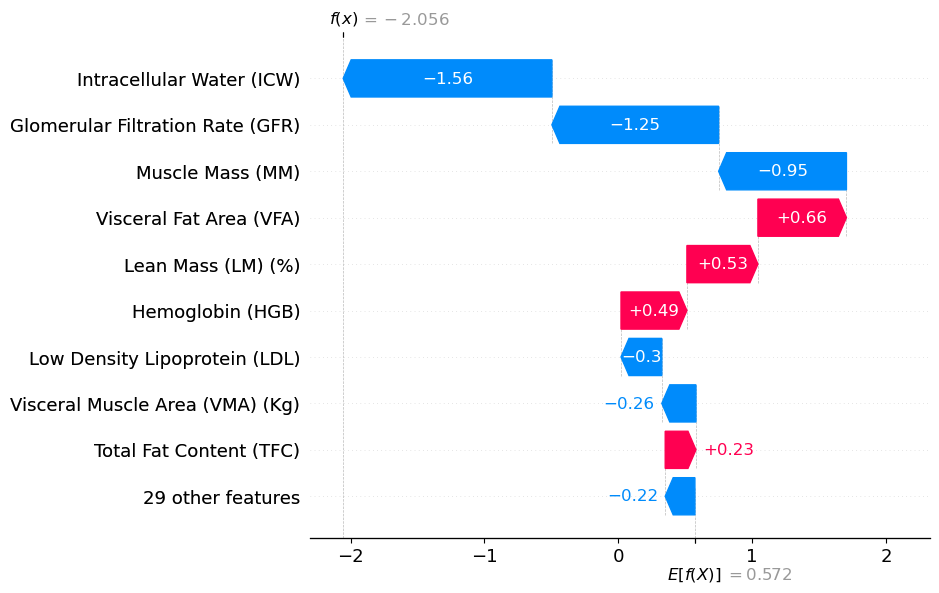

In [108]:
patient_idx = 0

shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values.values[patient_idx],       # use .values
    feature_names=feature_names,
    max_display=10
)


### Local Plot
   This waterfall plot show how features foe a single patient combine to push their predicted risk up or down:
   * Red bars = increase risk(Positive shaP value)
   * Blue bars = decrease risk(Negative shap value)
   * The base value(average model output) is shifted step by step until reaching the patient's final predicited probabiltity.

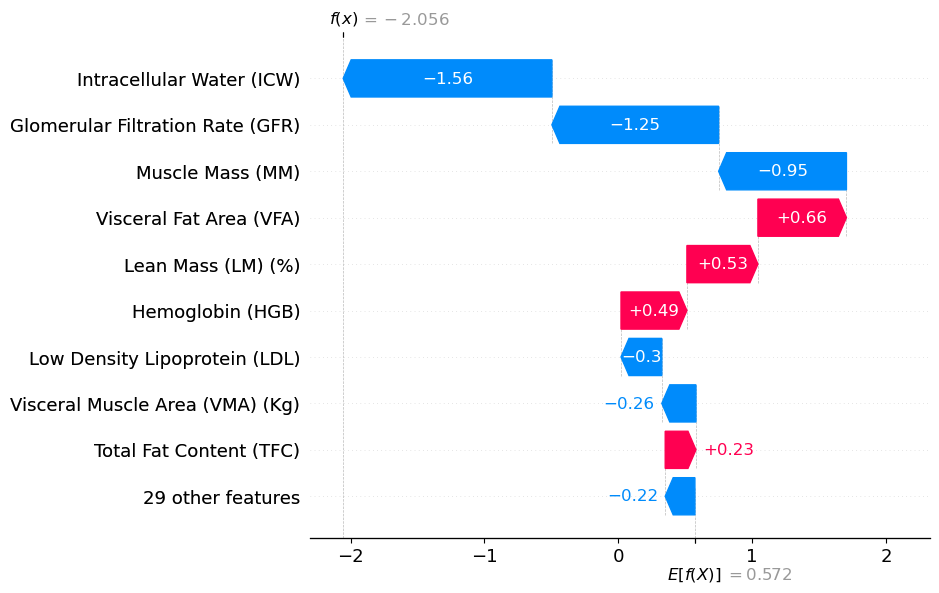

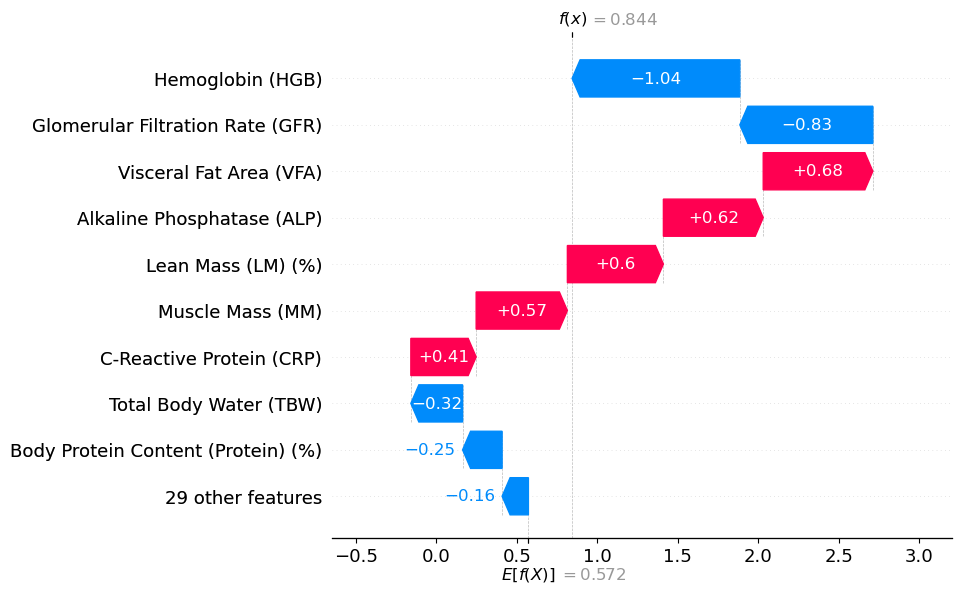

In [110]:
# Pick two patients with very different outcomes
for idx in [0, 10]:
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value,
        shap_values.values[idx, :],
        feature_names=feature_names,
        max_display=10
    )


### Comaprison between two patients
    comparing two different patient side by side shows how different risk factors dominate in different individuals.
    for example:
    -In one patient, high BMI may be the main driver.
    -In another, abnormal liver enzyme levels might dominate

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_patient_risk_card(patient_idx, 
                           X_raw,            # raw X_test DataFrame (original columns)
                           X_transformed,    # transformed X_test DataFrame (with num__ features)
                           shap_values, 
                           feature_names, 
                           model, 
                           threshold=None):
    """
    Create a risk card for an individual patient.
    
    Parameters
    ----------
    patient_idx : int
        Index of the patient in the test set.
    X_raw : pd.DataFrame
        Original test DataFrame with raw feature names (e.g. Age, BMI).
        Used for prediction with calibrated model.
    X_transformed : pd.DataFrame
        Transformed test DataFrame with engineered names (num__Age, cat__Gender_Female).
        Used for SHAP plotting.
    shap_values : np.array
        SHAP values array for the transformed dataset.
    feature_names : list
        Names of features corresponding to shap_values.
    model : sklearn model (CalibratedClassifierCV)
        Calibrated model to get probabilities.
    threshold : float, optional
        Threshold for risk labeling. Default = 0.5
    """
    # ---------------- Prediction (raw input) ----------------
    proba = calib_pipeline.predict_proba(X_raw.iloc[[patient_idx]])[:, 1][0]

    if threshold is None:
        threshold = 0.5
    risk_label = "High Risk" if proba >= threshold else "Low Risk"
    
    # ---------------- SHAP (transformed input) ----------------
    shap_patient = shap_values[patient_idx].values
    shap_patient = np.array(shap_patient)
    
    # Pick top absolute contributing features
    top_idx = np.argsort(np.abs(shap_patient))[-5:]
    top_features = [feature_names[i] for i in top_idx]
    top_values = shap_patient[top_idx]
    
    # ---------------- Plot ----------------
    plt.figure(figsize=(8, 5))
    colors = ["red" if val > 0 else "blue" for val in top_values]
    plt.barh(top_features, top_values, color=colors)
    plt.axvline(0, color="black", linewidth=1)
    plt.title(f"Patient {patient_idx} Risk Profile\n"
              f"Predicted Risk: {proba:.2f} → {risk_label}",
              fontsize=14, weight="bold")
    plt.xlabel("Feature Contribution to Risk (SHAP Value)")
    plt.tight_layout()
    plt.show()


In [113]:
# After transforming test data
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    feature_names = X_test.columns  # fallback if get_feature_names_out not available

X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

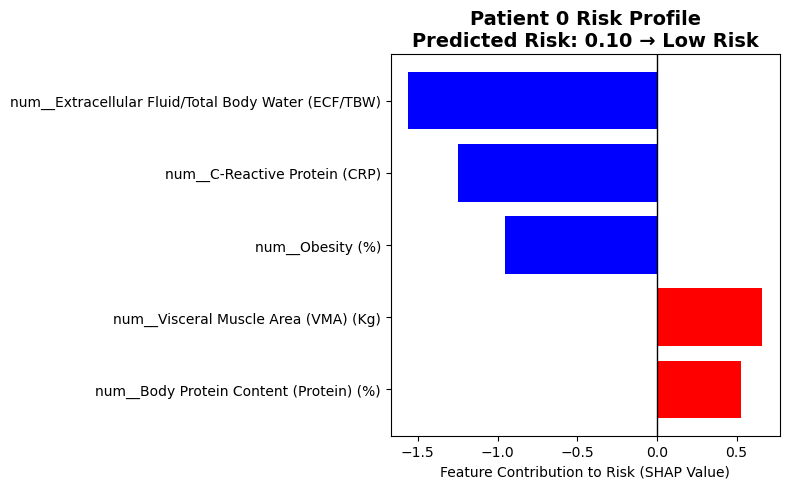

In [114]:
# After preprocessing and SHAP calculation:
feature_names = preprocessor.get_feature_names_out()
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

plot_patient_risk_card(
    0,
    X_test,          # raw
    X_test_df,       # transformed
    shap_values,
    feature_names,
    calib_pipeline,
    threshold=0.5
)


### Clinician-friendly summarized risk cards
  This "Risk Card" visualization provides a clinician-friendly summary of individual predicitions:
   - The prdidected probablity and risk category are displayed clearly.
   - The topn 5 features driving the predicition are shown as bars, with red=Increasing Risk and Blue=Decreasing Risk.
   - The function makes it easy to generate explanations for any patient in the dataset, supporting interactive exploration..

### Each patient’s risk profile is unique. Some features (e.g., Age, BMI) consistently appear across patients as important drivers of gallstone risk, reflecting their global importance. Other features differ between patients, showing individualized explanations. This balance illustrates how the model can support both population-level insights and personalized risk assessment.

## Partial Dependence & ICE Plots
### While SHAP values identify the most important features, Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots allow us to explore how predicted gallstone risk changes as a single feature varies.
### -"PDP shows the average relationship across all patients."
### -"ICE shows the same curve for individual patients, revealing variability."
These Plots help clinicians interpret the model in terms of "what-if" scenarios.
for ex. What happens to gallstone risk if BMI increases?

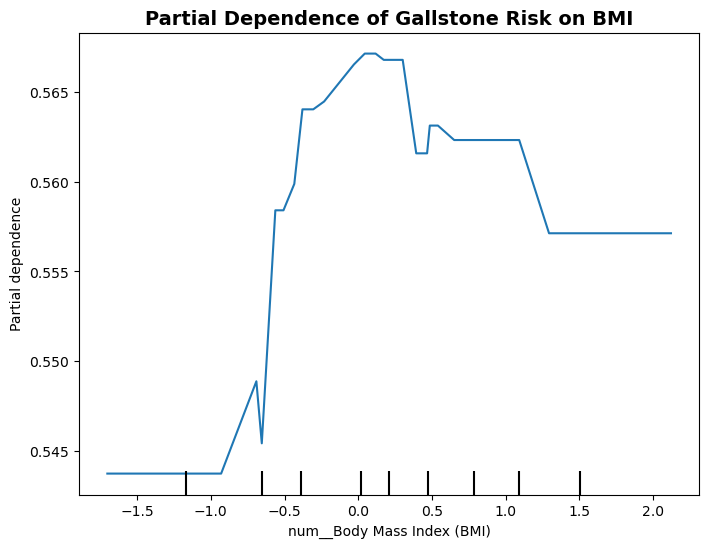

In [118]:
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
# Example: Partial dependence of BMI on gallstone risk
fig, ax = plt.subplots(figsize=(8,6))
PartialDependenceDisplay.from_estimator(
    xgb_estimator,
    X_test_transformed,
    features=[list(feature_names).index("num__Body Mass Index (BMI)")],  # replace with actual BMI column name
    feature_names=feature_names,
    ax=ax
)
plt.title("Partial Dependence of Gallstone Risk on BMI", fontsize=14, weight="bold")
plt.show()


#### This plot shows the average predicted gallstone risk as BMI increases, while holding all other features constant.
#### From the PDP above, we see that gallstone risk increases sharply as BMI rises above ~30, which is consistent with medical literature.
If the curve slopes upward, higher BMI consistently raises gallstone risk.  
PDP provides a global “what-if” view for a single feature.

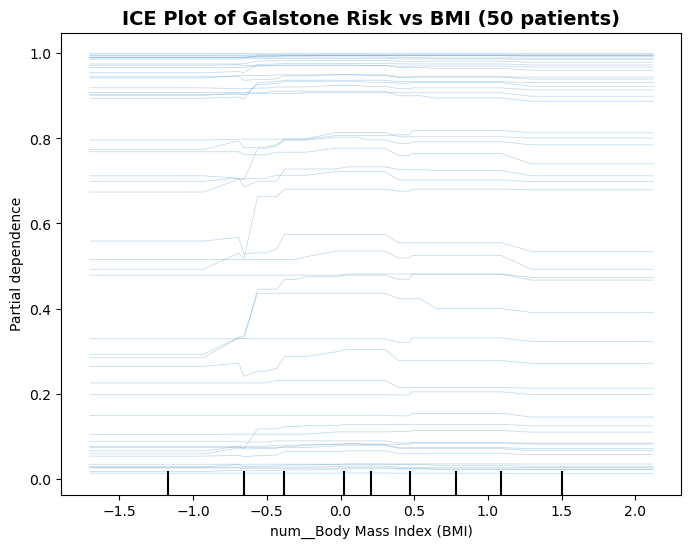

In [120]:
#ICE Plot for the same feature(BMI)
fig, ax = plt.subplots(figsize=(8,6))
PartialDependenceDisplay.from_estimator(
    xgb_estimator,
    X_test_transformed,
    features=[list(feature_names).index("num__Body Mass Index (BMI)")],
    feature_names=feature_names,
    kind="individual",   #ICE instead of average 
    ax=ax,
    subsample=50,   #limit patients for clarity
    random_state=42
)
plt.title("ICE Plot of Galstone Risk vs BMI (50 patients)", fontsize=14, weight="bold")
plt.show()

    

#### The ICE plot shows patient-level curves instead of just the average.
#### Each line = one patient, showing how their predicted risk changes as BMI varies.
If all lines slope upward together, the feature effect is consistent.
If lines cross/diverge, the effect varies by patient (heterogeneity).

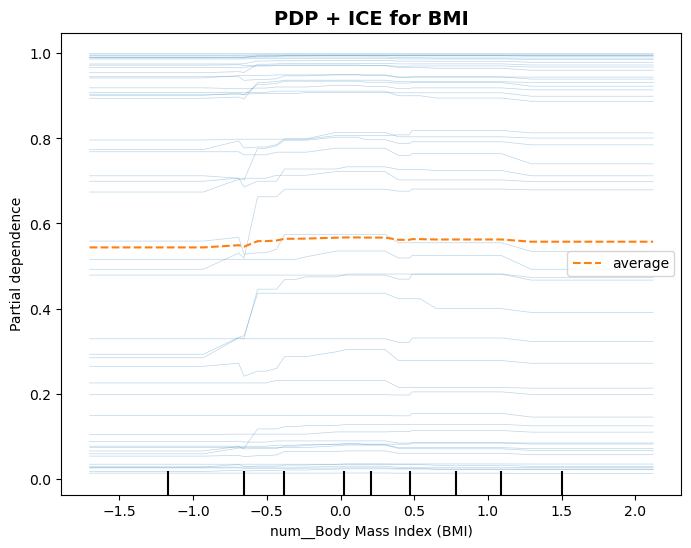

In [122]:
# Combined PDP + ICE for BMI
fig, ax = plt.subplots(figsize=(8,6))
PartialDependenceDisplay.from_estimator(
    xgb_estimator,
    X_test_transformed,
    features=[list(feature_names).index("num__Body Mass Index (BMI)")],
    feature_names=feature_names,
    kind="both",     # shows both PDP curve and ICE lines
    subsample=50,
    random_state=42,
    ax=ax
)
plt.title("PDP + ICE for BMI", fontsize=14, weight="bold")
plt.show()


#### The combined PDP+ICE plot overlays the global trend (PDP, thick line) with individual patient curves (ICE).

#### This clearly shows both the average relationship and individual variation, making it easier to explain to clinicians.

## Fairness & Bias Checks

### Why it matters:

    In healthcare AI, we must check if the model behaves fairly across subgroups.

    Example: Does it predict gallstone risk equally well for males vs females, or younger vs older patients?

    If the model is biased, clinicians won’t trust it.

In [125]:
import pandas as pd

# Assuming 'Gender' is a column in your raw test set
# Reload raw test data so we keep subgroup info (before preprocessing)
# test_df = pd.read_csv("../data/processed/test.csv")

# Separate features and target
X_test = test_df.drop(columns=["Gallstone Status"])
y_test = test_df["Gallstone Status"]

# Example subgroups: Male vs Female
mask_male = X_test["Gender"] == 1
mask_female = X_test["Gender"] == 0


print("Male samples:", mask_male.sum())
print("Female samples:", mask_female.sum())



Male samples: 27
Female samples: 21


##### Here we reload the test set with raw categorical columns (like Gender) so we can split performance by subgroup. We separate the features (X_test) and target (y_test), then create masks for Male and Female patients.

In [127]:
print(X_test["Gender"].unique())


[1 0]


In [128]:
print(X_test.columns.tolist())


['Age', 'Gender', 'Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Height', 'Weight', 'Body Mass Index (BMI)', 'Total Body Water (TBW)', 'Extracellular Water (ECW)', 'Intracellular Water (ICW)', 'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 'Body Protein Content (Protein) (%)', 'Visceral Fat Rating (VFR)', 'Bone Mass (BM)', 'Muscle Mass (MM)', 'Obesity (%)', 'Total Fat Content (TFC)', 'Visceral Fat Area (VFA)', 'Visceral Muscle Area (VMA) (Kg)', 'Hepatic Fat Accumulation (HFA)', 'Glucose', 'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)', 'High Density Lipoprotein (HDL)', 'Triglyceride', 'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 'Alkaline Phosphatase (ALP)', 'Creatinine', 'Glomerular Filtration Rate (GFR)', 'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D']


In [129]:
from sklearn.metrics import roc_auc_score, f1_score, brier_score_loss

def evaluate_subgroup(X, y, mask, group_name):
    """
    Compute AUROC, F1, and Brier score for a subgroup.
    X : Features (raw DataFrame, model pipeline handles preprocessing)
    y : Ground truth labels
    mask : Boolean mask for selecting subgroup samples
    group_name : Name of the subgroup (string)
    """
    # Predictions
    proba = calib_model.predict_proba(X[mask])[:, 1]
    preds = (proba >= saved_obj["threshold"]).astype(int)

    # Metrics
    auc = roc_auc_score(y[mask], proba) if mask.sum() > 0 else None
    f1 = f1_score(y[mask], preds) if mask.sum() > 0 else None
    brier = brier_score_loss(y[mask], proba) if mask.sum() > 0 else None

    print(f"📊 Subgroup: {group_name}")
    print(f"   Samples: {mask.sum()}")
    print(f"   AUROC  : {auc:.3f}")
    print(f"   F1     : {f1:.3f}")
    print(f"   Brier  : {brier:.3f}")
    print("-"*40)
    
    return {"group": group_name, "n": mask.sum(), "AUROC": auc, "F1": f1, "Brier": brier}


In [130]:

# Important: keep raw X_test separate
X_test_raw = X_test.copy()       # raw DataFrame with original names
X_test_transformed = preprocessor.transform(X_test_raw)  # transformed array

feature_names = preprocessor.get_feature_names_out()
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

explainer = shap.Explainer(xgb_estimator, X_test_transformed)
shap_values = explainer(X_test_transformed)



# Masks for gender subgroups
mask_male = X_test_raw["Gender"] == 1
mask_female = X_test_raw["Gender"] == 0

print("✅ Male samples:", mask_male.sum())
print("✅ Female samples:", mask_female.sum())


✅ Male samples: 27
✅ Female samples: 21


In [131]:
def evaluate_subgroup(X, y, mask, group_name, model, features=None):
    """
    Evaluate model performance on a subgroup.
    
    Parameters
    ----------
    X : pd.DataFrame or np.ndarray
        Test features (raw DataFrame preferred).
    y : array-like
        True labels.
    mask : boolean array
        Mask selecting subgroup samples.
    group_name : str
        Name of the subgroup.
    model : sklearn model
        Trained model with predict_proba.
    features : list, optional
        Feature names (needed if X is array).
    """
    import numpy as np
    import pandas as pd
    from sklearn.metrics import roc_auc_score, f1_score, brier_score_loss

    # ✅ Ensure DataFrame
    if not isinstance(X, pd.DataFrame):
        if features is None:
            raise ValueError("If X is array, you must provide features list.")
        X = pd.DataFrame(X, columns=features)

    # Apply mask
    X_sub = X.loc[mask]
    y_sub = y[mask]

    # Predictions
    y_pred_proba = model.predict_proba(X_sub)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Metrics
    auc = roc_auc_score(y_sub, y_pred_proba)
    f1 = f1_score(y_sub, y_pred)
    brier = brier_score_loss(y_sub, y_pred_proba)

    return {
        "group": group_name,
        "n": mask.sum(),
        "AUROC": auc,
        "F1": f1,
        "Brier": brier
    }


In [132]:
results = []
results.append(evaluate_subgroup(X_test_raw, y_test, mask_male, "Male", calib_pipeline))
results.append(evaluate_subgroup(X_test_raw, y_test, mask_female, "Female", calib_pipeline))


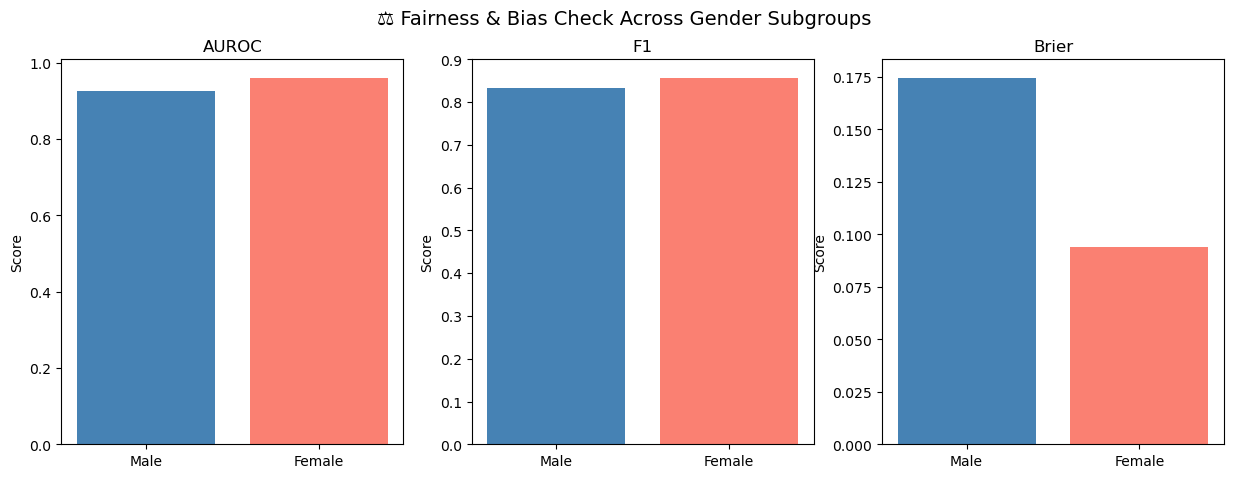

In [133]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot subgroup metrics
fig, axes = plt.subplots(1, 3, figsize=(15,5))

metrics = ["AUROC", "F1", "Brier"]

for i, metric in enumerate(metrics):
    axes[i].bar(results_df["group"], results_df[metric], color=["steelblue", "salmon"])
    axes[i].set_title(metric)
    axes[i].set_ylabel("Score")

plt.suptitle("⚖️ Fairness & Bias Check Across Gender Subgroups", fontsize=14)
plt.show()


In [134]:
# Compute median age to split groups
median_age = X_test["Age"].median()
print("📌 Median Age:", median_age)

# Define masks
mask_younger = X_test["Age"] <= median_age
mask_older = X_test["Age"] > median_age

print("✅ Younger samples:", mask_younger.sum())
print("✅ Older samples:", mask_older.sum())


📌 Median Age: 51.5
✅ Younger samples: 24
✅ Older samples: 24


In [135]:
# Add Age subgroup evaluations
results.append(evaluate_subgroup(X_test, y_test, mask_younger, "Younger (≤ median age)", calib_pipeline))
results.append(evaluate_subgroup(X_test, y_test, mask_older, "Older (> median age)", calib_pipeline))


In [136]:
# Convert results into DataFrame and normalize column names
results_df = pd.DataFrame(results)

# Standardize column names and rename user-friendly labels
rename_map = {
    "group": "Group",
    "n": "Samples",
    "AUROC": "AUROC",
    "F1": "F1",
    "Brier": "Brier"
}
# Only rename keys that exist
existing_rename = {k:v for k,v in rename_map.items() if k in results_df.columns}
results_df = results_df.rename(columns=existing_rename)

# Reorder if possible
cols_wanted = ["Group", "Samples", "AUROC", "F1", "Brier"]
cols_present = [c for c in cols_wanted if c in results_df.columns]
results_df = results_df[cols_present]

# Round numeric metrics for display
for c in ["AUROC", "F1", "Brier"]:
    if c in results_df.columns:
        results_df[c] = results_df[c].apply(lambda x: round(x, 3) if pd.notnull(x) else x)

# set index to Group and display
if "Group" in results_df.columns:
    display(results_df.set_index("Group"))
else:
    # fallback: just display the frame
    display(results_df)


,Samples,AUROC,F1,Brier
Group,,,,
Male,27,0.926,0.833,0.175
Female,21,0.962,0.857,0.094
Younger (≤ median age),24,0.893,0.762,0.161
Older (> median age),24,0.943,0.897,0.117


In [137]:
import os
import datetime

# Make sure result folder exists
OUT_DIR = "result"
os.makedirs(OUT_DIR, exist_ok=True)

# Use the DataFrame you've already prepared: results_df
# Add a timestamp suffix for unique filenames
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
base_name = f"fairness_by_gender_{ts}"
csv_path = os.path.join(OUT_DIR, base_name + ".csv")
json_path = os.path.join(OUT_DIR, base_name + ".json")
pkl_path = os.path.join(OUT_DIR, base_name + ".pkl")

# 1) Save as CSV (flat table)
results_df.to_csv(csv_path, index=False)
print(f"Saved CSV -> {csv_path}")

# 2) Save as JSON (records orient keeps rows as objects)
# This preserves nulls and types better for nested structures
results_df.to_json(json_path, orient="records", date_format="iso")
print(f"Saved JSON -> {json_path}")

# 3) Save as Pickle (fast, preserves dtypes)
results_df.to_pickle(pkl_path)
print(f"Saved Pickle -> {pkl_path}")

Saved CSV -> result\fairness_by_gender_20250918_170555.csv
Saved JSON -> result\fairness_by_gender_20250918_170555.json
Saved Pickle -> result\fairness_by_gender_20250918_170555.pkl


In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [139]:
def net_benefit(y_true, y_pred_prob, thresholds):
    """
    Compute net benefit for model, treat-all, and treat-none strategies.
    """
    N = len(y_true)
    results = []

    for t in thresholds:
        # Predictions at threshold t
        preds = (y_pred_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()

        # Model net benefit
        nb_model = (tp/N) - (fp/N) * (t / (1 - t))

        # Treat all (assume all patients positive)
        nb_all = (np.sum(y_true) / N) - (N - np.sum(y_true)) / N * (t / (1 - t))

        # Treat none (assume no patient positive)
        nb_none = 0

        results.append({"threshold": t, "Model": nb_model, "All": nb_all, "None": nb_none})
 
    return pd.DataFrame(results)


In [140]:
# Get the inner calibrated classifier
inner_model = calib_pipeline.base_estimator if hasattr(calib_pipeline, "base_estimator") else calib_pipeline

# Now predict using the pipeline directly
y_proba = inner_model.predict_proba(X_test)[:, 1]

print("✅ y_proba shape:", y_proba.shape)


✅ y_proba shape: (48,)


In [141]:
# --- Predict probabilities ---
y_proba = calib_pipeline.predict_proba(X_test)[:, 1]

# --- Define thresholds to evaluate ---
thresholds = np.linspace(0.01, 0.99, 50)

# --- Compute decision curve analysis (DCA) results ---
dca_results = net_benefit(y_test, y_proba, thresholds)

print(dca_results.head())   # check structure


   threshold     Model       All  None
0       0.01  0.494949  0.494949     0
1       0.03  0.484536  0.484536     0
2       0.05  0.473684  0.473684     0
3       0.07  0.471774  0.462366     0
4       0.09  0.475275  0.450549     0


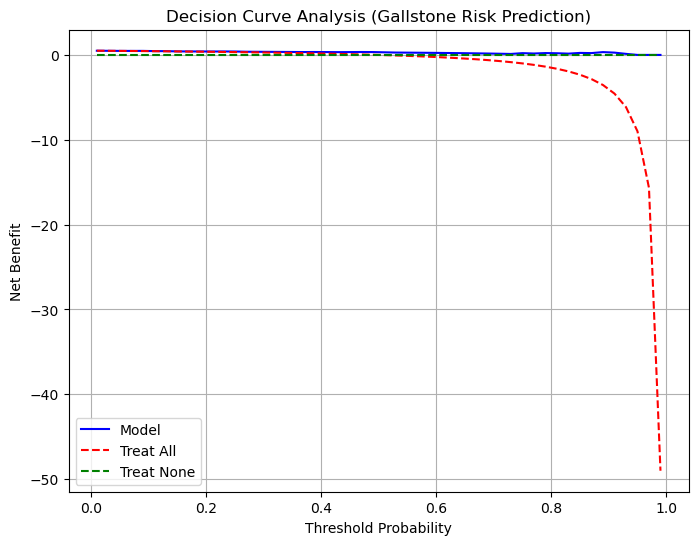

In [142]:
plt.figure(figsize=(8,6))
plt.plot(dca_results["threshold"], dca_results["Model"], label="Model", color="blue")
plt.plot(dca_results["threshold"], dca_results["All"], label="Treat All", color="red", linestyle="--")
plt.plot(dca_results["threshold"], dca_results["None"], label="Treat None", color="green", linestyle="--")

plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (Gallstone Risk Prediction)")
plt.legend()
plt.grid(True)
plt.show()


### Decision Curve Analysis
#### Why DCA?
##### It evaluates the clinical usefulness of the model compared to always treating or never treating patients.
#### Interpretation:
##### If the Model curve is above both Treat All and Treat None → the model provides clinical benefit. Doctors can choose the threshold range where the model gives the highest net benefit.